In [1]:
from kalman import KalmanBoxTracker
tracker = KalmanBoxTracker([10, 10, 20, 20])
prediction = tracker.predict()
update = tracker.update([11, 11, 19, 19])

prediction, update

(array([[10.],
        [10.],
        [20.],
        [20.]]),
 array([[10.67741935],
        [10.67741935],
        [19.32258065],
        [19.32258065]]))

In [2]:
import torchvision.models as models
import torch
from kalman import KalmanBoxTracker
import torch
import numpy as np
import os
import cv2
from collections import defaultdict
import tensorflow
from torchvision.transforms import functional as F
from scipy.optimize import linear_sum_assignment
import cv2
import numpy as np
from IPython.display import display
from PIL import Image
import numpy as np


# Load a pre-trained YOLO model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\Y954455\AppData\Local\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Y954455\AppData\Local\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:

def read_annotations(sequence_path):
    # Define the path to the ground truth annotations file
    gt_path = os.path.join(sequence_path, 'gt', 'gt.txt')

    # Read the file and split into lines
    with open(gt_path, 'r') as file:
        lines = file.readlines()

    # Process each line into structured data
    annotations = []
    for line in lines:
        # Split each line by comma
        elements = line.strip().split(',')

        # Extract information
        frame_num = int(elements[0])
        object_id = int(elements[1])
        x, y, w, h = map(float, elements[2:6])
        class_id = int(elements[7])

        # Append to the annotations list
        annotations.append((frame_num, object_id, x, y, w, h, class_id))

    return annotations

# Example usage
sequence_path = "MOT16/train/MOT16-02"  # Replace with the path to a sequence
annotations = read_annotations(sequence_path)

In [4]:


def group_annotations_by_frame(annotations):
    grouped_annotations = defaultdict(list)
    for annotation in annotations:
        frame_num = annotation[0] - 1
        grouped_annotations[frame_num].append(annotation[1:])
    return grouped_annotations

# Example usage
grouped_annotations = group_annotations_by_frame(annotations)


In [5]:


def load_images(sequence_path):
    img_folder_path = os.path.join(sequence_path, 'img1')
    image_files = sorted(os.listdir(img_folder_path))
    images = [cv2.imread(os.path.join(img_folder_path, img)) for img in image_files]
    return images

# Example usage
images = load_images(sequence_path)

In [6]:
len(images), len(annotations)

(600, 29193)

In [7]:


def preprocess_image(image):
    # Convert BGR image to RGB
    # image = image[..., ::-1]
    # Convert to PyTorch tensor
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image_tensor.to(device)

In [8]:
# Assuming `images` is the list of images loaded previously

for image in images:
    # Preprocess the image
    image_tensor = preprocess_image(image)
    
    # Run the image through the model
    with torch.no_grad():
        prediction = model(image_tensor)

    # Process the predictions as needed
    # The `prediction` object contains the detected bounding boxes, labels, and scores
    # print(prediction)
    break

In [9]:
outputs = model(image_tensor)

outputs[0].keys()

dict_keys(['boxes', 'labels', 'scores'])

In [10]:
boxes = outputs[0]['boxes'].detach().cpu().numpy()

In [11]:


def clip_boxes(boxes, image_shape):
    boxes[:, 0] = np.clip(boxes[:, 0], 0, image_shape[1] - 1)
    boxes[:, 1] = np.clip(boxes[:, 1], 0, image_shape[0] - 1)
    boxes[:, 2] = np.clip(boxes[:, 2], 0, image_shape[1] - 1)
    boxes[:, 3] = np.clip(boxes[:, 3], 0, image_shape[0] - 1)
    return boxes

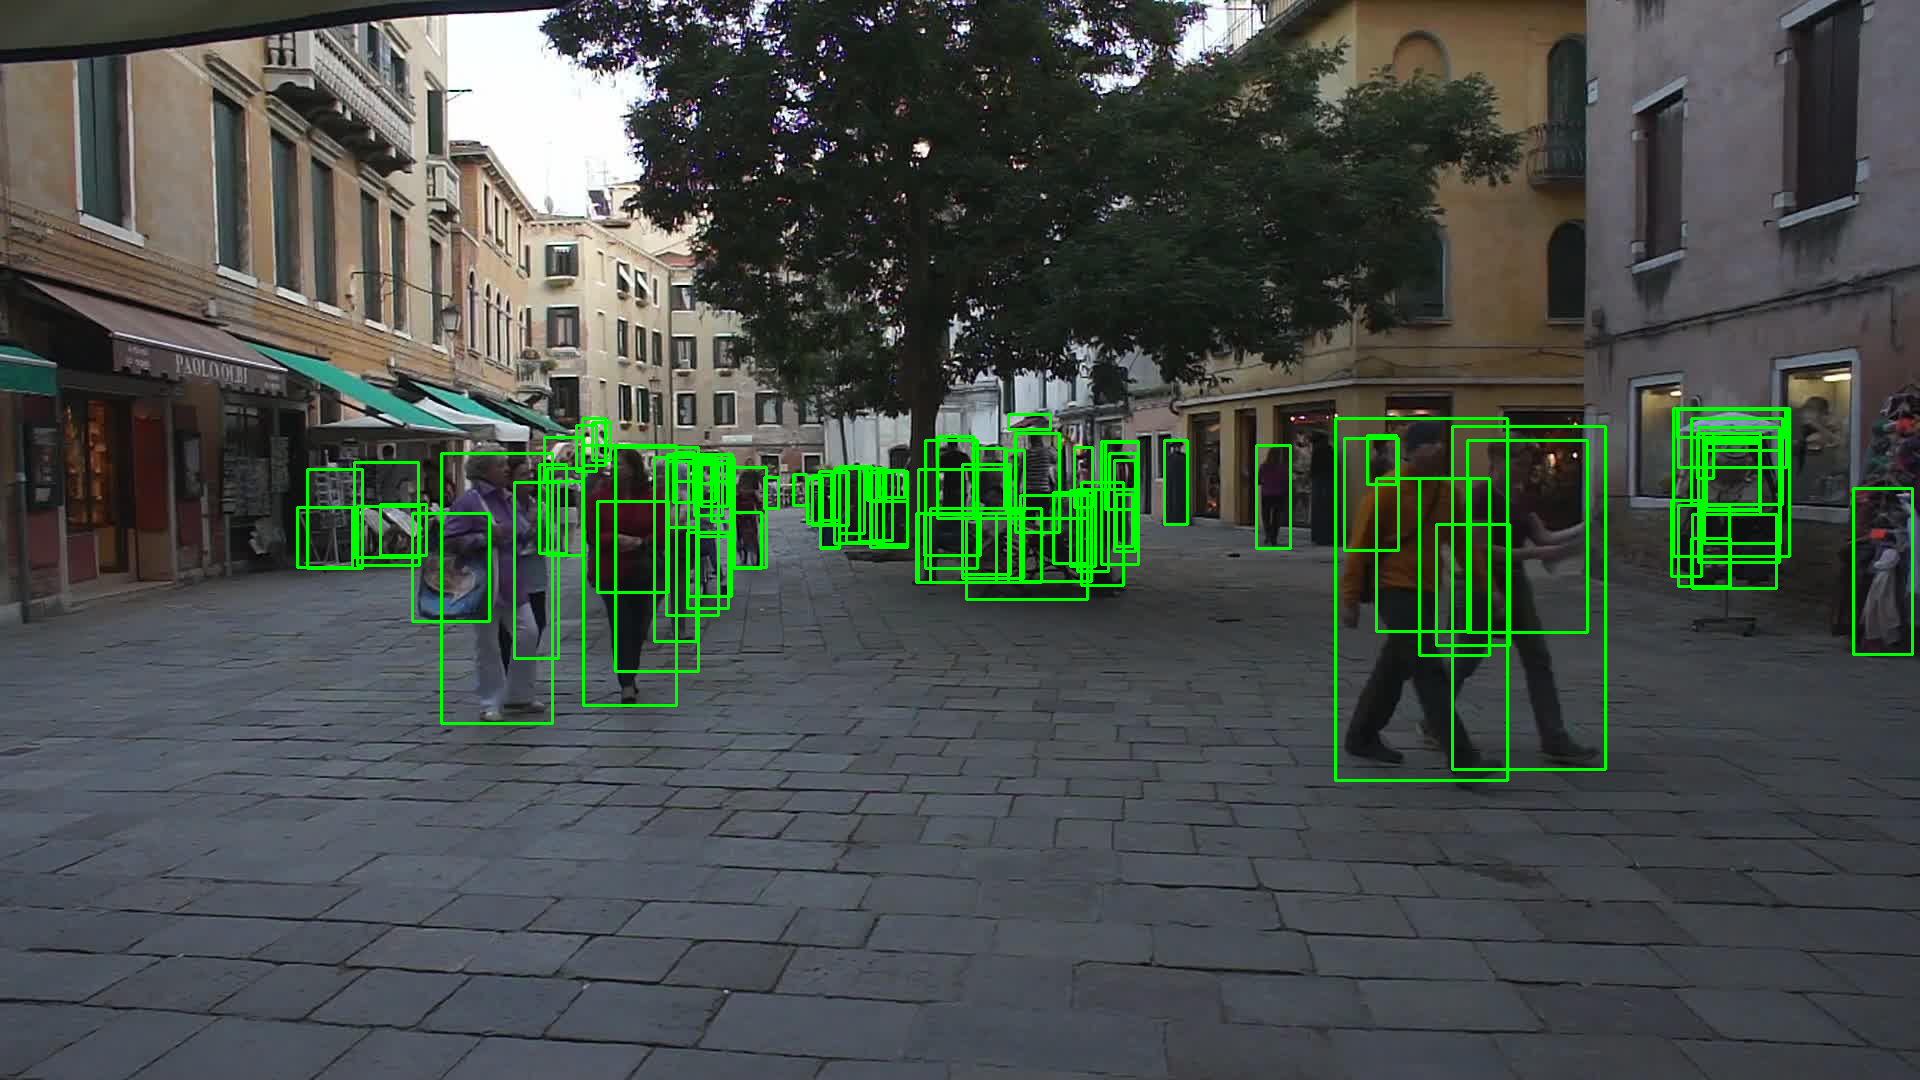

In [12]:

def plot_image_with_boxes(image, boxes):
    # Copy the image so the original is not modified
    image_copy = image.copy()

    # Add bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Convert the BGR image (OpenCV default) to RGB
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

    # Convert to PIL Image and display
    display(Image.fromarray(image_copy))
plot_image_with_boxes(image, boxes)

In [13]:

def iou(bbox1, bbox2):
    """
    Bounding boxes are represented as [x, y, w, h].
    """
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    x_int = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_int = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    intersection = x_int * y_int
    union = w1 * h1 + w2 * h2 - intersection
    return intersection / union

def associate_detections(detections1, detections2, iou_threshold=0.3):
    """
    Associate detections from two consecutive frames using IoU and the Hungarian algorithm.
    Returns the matched indices from both frames.
    """
    # Calculate the IoU between all pairs of detections
    iou_matrix = np.array([[iou(det1, det2) for det2 in detections2] for det1 in detections1])
    
    # Apply the Hungarian algorithm to find the optimal association
    matched_rows, matched_cols = linear_sum_assignment(-iou_matrix)
    
    # Filter matches based on the IoU threshold
    matches = [(r, c) for r, c in zip(matched_rows, matched_cols) if iou_matrix[r, c] >= iou_threshold]
    
    return matches

# Example usage
detections1 = [[10, 10, 20, 20], [30, 30, 40, 40]]
detections2 = [[11, 11, 19, 19], [31, 31, 39, 39]]
matches = associate_detections(detections1, detections2)

matches

[(0, 0), (1, 1)]

In [14]:
class TrackManager:
    def __init__(self, max_missed=3):
        """
        Initialize the track manager.
        max_missed: Maximum number of consecutive missed detections allowed for a track before deletion.
        """
        self.tracks = []  # List of active tracks (KalmanBoxTracker objects)
        self.max_missed = max_missed
    
    def predict(self):
        """
        Predict the next state for all tracks.
        """
        for track in self.tracks:
            track.predict()

    def update(self, detections):
        # Initialize matches as an empty list
        matches = []
    
        if self.tracks:  # Only associate detections if there are existing tracks
            # Associate detections with existing tracks
            matches = associate_detections(
                [np.reshape(track.kf.x[:4], (4,)) for track in self.tracks],detections
            )
    
            # Update matched tracks and mark unmatched tracks as missed
            unmatched_tracks = list(range(len(self.tracks)))
            for track_idx, detection_idx in matches:
                self.tracks[track_idx].update(detections[detection_idx])
                unmatched_tracks.remove(track_idx)
    
            # Increment the missed count for unmatched tracks
            for track_idx in unmatched_tracks:
                self.tracks[track_idx].missed += 1
    
            # Delete tracks that have been missed too many times
            self.tracks = [track for track in self.tracks if track.missed <= self.max_missed]
    
        # Create new tracks for unmatched detections
        unmatched_detections = set(range(len(detections))) - set(match_idx for _, match_idx in matches)
        for detection_idx in unmatched_detections:
            self.tracks.append(KalmanBoxTracker(detections[detection_idx]))

    
    def get_active_tracks(self):
        """
        Get the active tracks for visualization or further processing.
        Returns a list of bounding boxes for the active tracks.
        """
        return [track.kf.x[:4] for track in self.tracks]

# Replace the existing update method in the TrackManager class with this corrected version
# TrackManager.update = update_tracks

# Example usage
track_manager = TrackManager()
track_manager.update(detections1)  # First frame
track_manager.predict()
track_manager.update(detections2)  # Second frame

active_tracks = track_manager.get_active_tracks()
active_tracks

[array([[10.67741935],
        [10.67741935],
        [19.32258065],
        [19.32258065]]),
 array([[30.67741935],
        [30.67741935],
        [39.32258065],
        [39.32258065]])]